In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline 

In [2]:
data = pd.read_excel('./Istanbul_StockMarket_09-11.xlsx', header=2)
data['date'] = pd.to_datetime(data.date)
feature_name = 'USD BASED ISE'
data = data[['date', feature_name]]
data.set_index('date');

In [3]:
# data = pd.read_csv('./istanbul_stock_exchange.csv')
# data['date'] = pd.to_datetime(data.date)
# feature_name = 'NIKKEI'
# data = data[['date', 'NIKKEI']]
# data.set_index('date');

In [4]:
data.tail()

,date,USD BASED ISE
531,2011-02-16,0.013400
532,2011-02-17,0.015977
533,2011-02-18,-0.001653
534,2011-02-21,-0.013706
535,2011-02-22,-0.019442


In [5]:
selected_process = data[feature_name]

In [6]:
print('Mean: ', selected_process.mean(), end='\n')
print('Variance: ', selected_process.var(), end='\n')

Mean:  0.0015522255599999997
Variance:  0.0004461357294142768


In [7]:
selected_process.cov(selected_process)

0.00044613572941427714

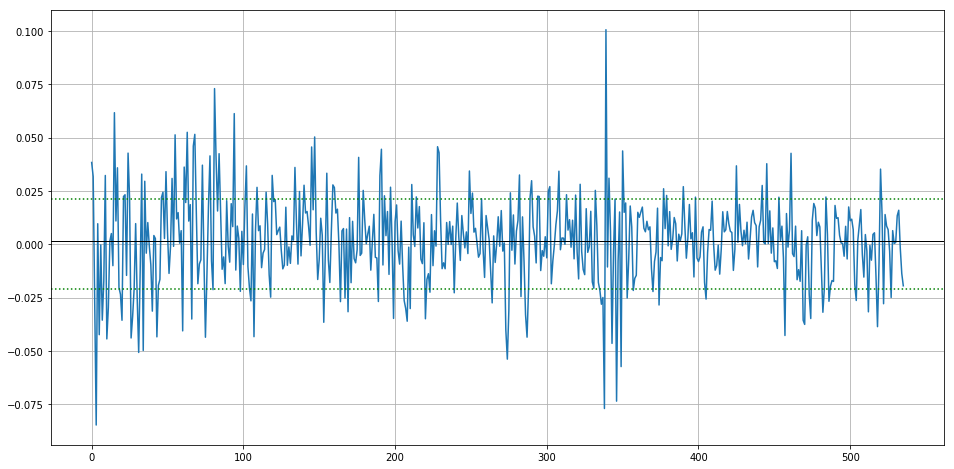

In [8]:
selected_process.plot(figsize=(16, 8));
plt.axhline(y=selected_process.mean(), color='black', linestyle='-', linewidth=1)
plt.axhline(y=selected_process.std(), color='green', linestyle=':')
plt.axhline(y=-selected_process.std(), color='green', linestyle=':');
plt.grid()

autocovariance

In [9]:
def corrected_selective_correlation_function(values, selective_average, k):
    sum = 0.0
    for i in range(len(values)-k):
        sum += (values[i]-selective_average)*(values[i+k]-selective_average)
    return sum/(len(values)-k-1)

In [10]:
m = selected_process.size - 10
Rk = []
for i in range(m):
    Rk.append(corrected_selective_correlation_function(selected_process, selected_process.mean(), i))
rk = np.array(Rk) / selected_process.var()

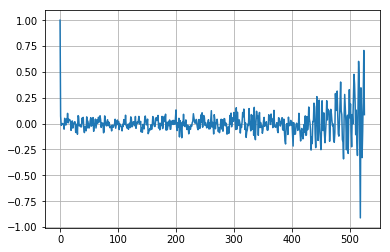

In [11]:
plt.plot(range(m), rk)
plt.grid()

In [12]:
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

D:\Programs\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [13]:
ts = data[feature_name]

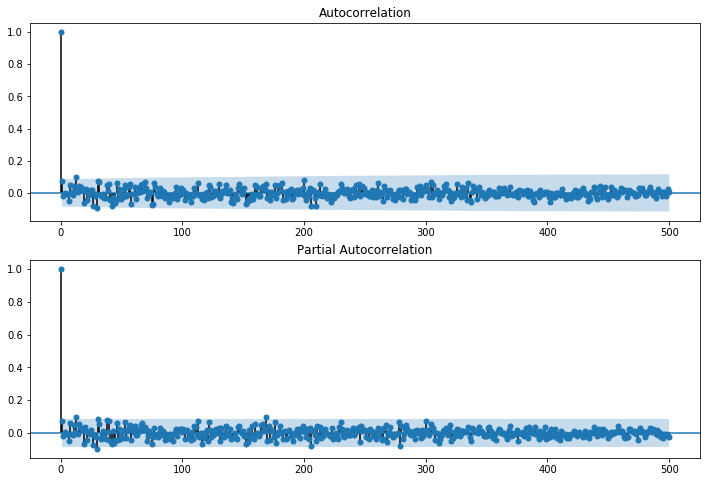

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags = 500, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags = 500, ax = ax2) # в случае частной автокорреляции остальные переменные не влияют

$\textbf{Скользящее среднее:}$

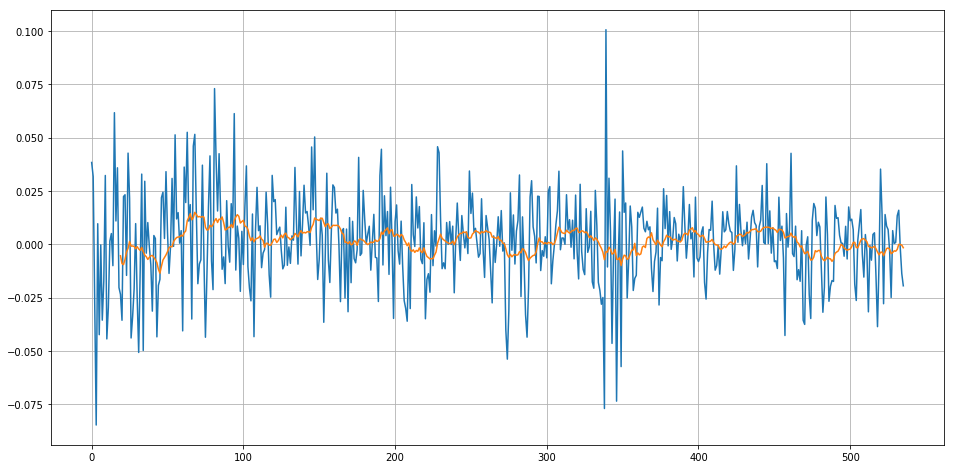

In [15]:
moving_avg = ts.rolling(window=20,center=False).mean()
ts.plot(figsize=(16, 8))
plt.grid()
plt.plot(moving_avg)

#### Тест Дики-Фуллера

Нестационарный временной ряд соответствует случаю p-value = 1

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
def test_stationarity(timeseries):
    rolmaen = ts.rolling(window=20,center=False).mean()
    rolstd = ts.rolling(window=20,center=False).std()
    
    plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmaen, color='red', label='Rolling Mean')
    std_p = plt.plot(rolstd, color='black', label='Rolling Std')
    std_m = plt.plot(-rolstd, color='black')
    plt.grid()
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])
    return dfoutput

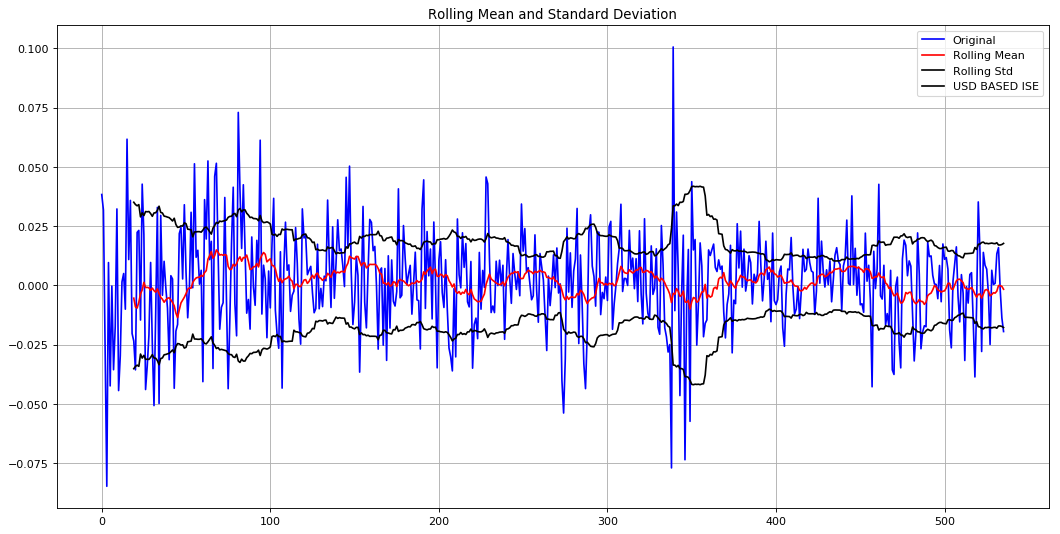

Results of Dickey-Fuller Test:


Test Statistic   -21.510292
p-value            0.000000
dtype: float64

In [18]:
test_stationarity(ts)

#### Модель авторегрессии AR

In [19]:
from statsmodels.tsa.arima_model import ARIMA

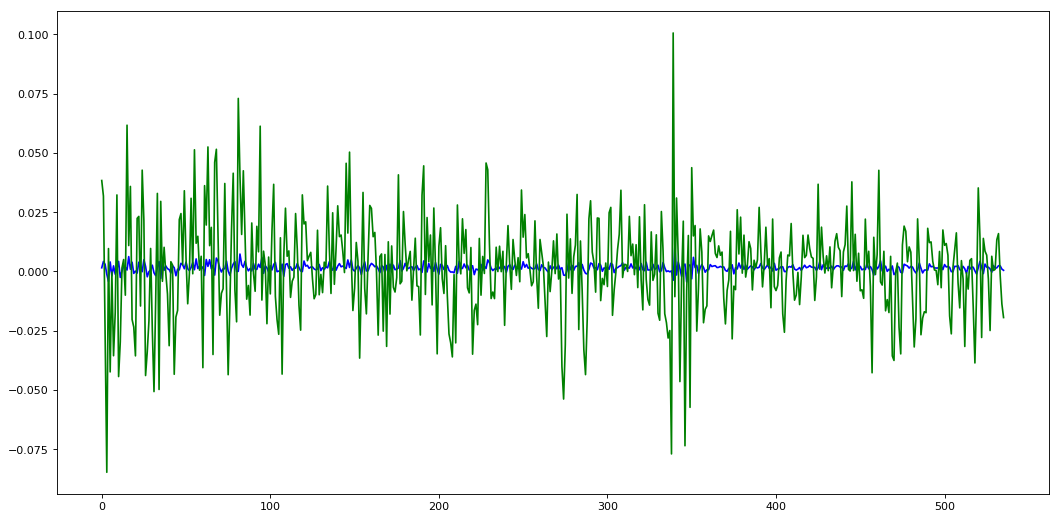

In [20]:
model = ARIMA(np.array(ts), order=(2,0,0))
results_AR = model.fit(disp=-1)
plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(results_AR.fittedvalues, color='blue')
plt.plot(ts, color='green')

In [21]:
def ar_params_parameters(ts, order):
    matrix = np.matrix(np.array([[ auto_cov(ts.values, tau=abs(j-i)) 
                             for j in range(1, order+1)] for i in range(1, order+1)]))  
    vec = [auto_cov(ts.values, tau=i) for i in range(1, order+1)]  
    return np.linalg.solve(matrix, vec)

In [75]:
def ARModel(ts, order):
    EF = ar_params_parameters(ts, order)
    pred = np.zeros(data.shape[0])
    for t in range(order, ts.shape[0]):
        pred[t] = sum([EF[i]*data[t-i-1] for i in range(order)])
    return pred   

In [77]:
arm = pd.Series(ARModel(ts, order=2))
plt.figure(figsize=(16, 8))
ax = ts.plot(label='Source time series')
arm.plot(label='Autoregression model', color='green')
plt.grid()
plt.show()

In [ ]:
def get_error(order, ts):
    orders = list(range(order[0], order[1]+1))
    errors = []
    y_real = np.array(ts.values)
    for ord in orders:
        pred = np.array(AR_Model(ts, order))
        errors.append((pred-y_real).mean())
    return orders, errors

In [ ]:
x, y = find_optimal(order=(1,10))
ap,ax=plt.subplots(figsize=(20,8))
plt.plot(x, y, label='Mean error')
ax.set(xlabel='Order of AR Model', ylabel='Mean error')
plt.grid()
plt.show()

In [ ]:
src_data_model = np.array(data[feature_name])
model = sm.tsa.ARIMA(fx, order=(2,0,0), freq='W').fit(full_output=True)

In [ ]:
print(model.summary())

In [ ]:
#Анализ и оценка модели
#
#Проверим остатки данной модели на соответствие «белому шуму», а также проанализируем коррелограму остатков, так как это может нам помочь в определении важных для включения и прогнозирования элементов регрессии.
#Итак первое, что мы сделаем это проведем Q-тест Льюнга — Бокса для проверки гипотезы о том, что остатки случайны, т. е. являются «белым шумом». Данный тест проводится на остатках модели ARIMA. Таким образом, нам надо сначала получить остатки модели и построить для них ACF, а затем к получившимся коэффициентам приметить тест. С помощью statsmadels это можно сделать так:

In [ ]:
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print(pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [ ]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [ ]:
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=20)

In [ ]:
pd.rolling_corr(ts, window=20)[100:110]

Spectrum dencity

In [ ]:
from scipy.fftpack import fft, ifft, fftshift
from statsmodels.tsa.stattools import acf

In [ ]:
from scipy import signal

In [ ]:
spec = ifft(acf(selected_process, nlags=500))

In [ ]:
f, Pxx_spec = signal.periodogram(ts)
plt.figure(figsize=(16, 8))
plt.plot(ts[:500])
plt.plot(spec)

Err

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

# Plot the Raw Data
plt.plot(ts, 'r-')
plt.ylabel('Lightpower (V)')

smooth_data = pd.rolling_mean(ts,5).plot(style='k')
plt.show()

Spectral density

In [ ]:
def barlett2(t, tau_max):
    return 0 if t > tau_max  else 1 - math.fabs(t)/tau_max
       
def hamming(t, tau_max):
    return 0 if t > tau_max else 0.54 + 0.46 * math.cos((math.pi * t)/tau_max)
    
def parsen2(t, tau_max):
    if t > tau_max: return 0
    elif t > 0.5*tau_max:
        return 2*(1-t/tau_max)**3
    else:
        return 1 - 6*(t/tau_max)**2 + 6*(t/tau_max)**3

In [ ]:
def S(w, data, M, kernel, delta_tau):
    return sum([kernel(tau, M)*auto_cov(data, tau)\
                *math.cos(w*tau)*delta_tau for tau in range(1, M)])/math.pi

In [ ]:
def blackman_tukey(data, ts, ws, window, t_max = 50):
    result = []
    acvs = [auto_cov(data, lag) for lag in ts]
    for w in ws:
        sum_ = 0
        for i in range(1, len(ts)):
            t = ts[i]
            dt = t - ts[i - 1]
            sum_ += window(t, t_max) * acvs[i] * math.cos(w * t) * dt
        result.append(sum_/math.pi)
    return result

In [ ]:
def auto_cov(data, tau, cor):
    _mean = data.mean()
    var = data.var()
    _values = data.values
    N = len(_values)
    if cor:
        return np.array([(_values[t]-_mean)*(_values[t+tau]-_mean)  for t in range(0, N-tau)]).mean()/var
    else:
        return np.array([(_values[t]-_mean)*(_values[t+tau]-_mean)  for t in range(0, N-tau)]).mean()

In [ ]:
ws = [i for i in np.arange(0, 1, 0.01)]    
plt.figure(figsize=(16, 8))
taumax = 120
plt.grid()
plt.xlabel('Freq')
plt.ylabel('Spectrum density') 
plt.plot(ws, [S(w, ts, taumax, barlett2) for w in ws], label='Barlett (modified)')
plt.plot(ws, [S(w, ts, taumax, hamming) for w in ws], label='Hamming')
plt.plot(ws, [S(w, st, taumax, parsen2) for w in ws], label='Parsen (2)')
plt.legend()
plt.show()

In [64]:
spec = ifft(acf(selected_process, nlags=500))

D:\Programs\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


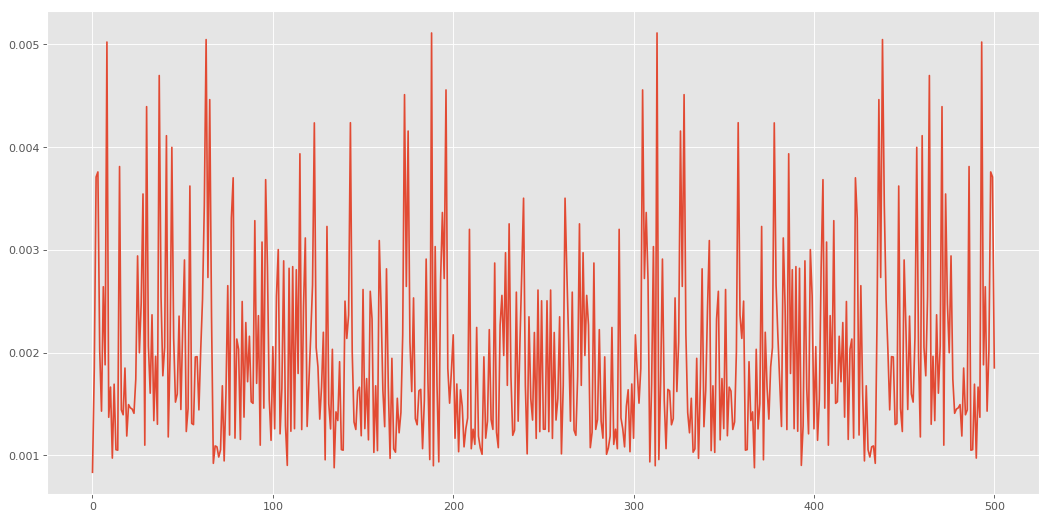

In [65]:
plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(spec)
# plt.plot(Rk)

In [67]:
def autocorr(x, t=1):
    return np.corrcoef(np.array([x[0:len(x)-t], x[t:len(x)]]))

gausian filter

In [40]:
import scipy.ndimage.filters as filters
fx = filters.gaussian_filter1d(ts,sigma=3)

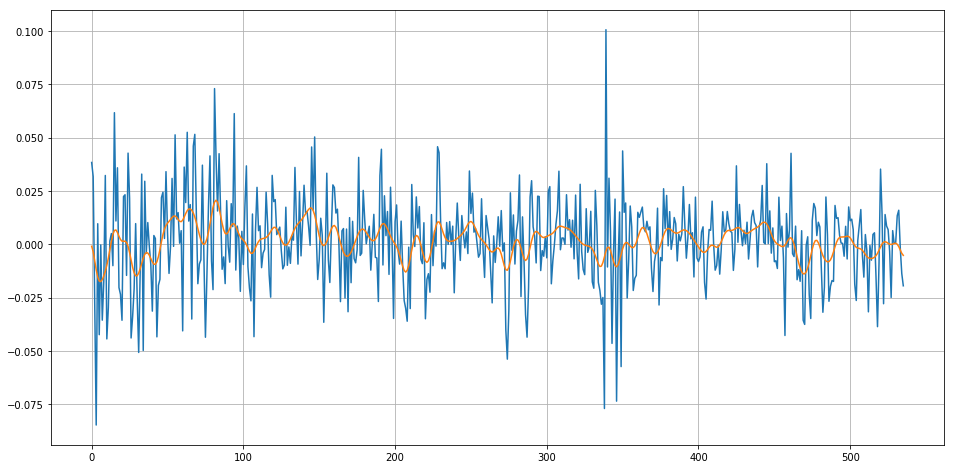

In [42]:
plt.figure(figsize=(16, 8))
plt.grid()
plt.plot(ts)
plt.plot(fx);

In [184]:
from scipy import signal

Text(0.5,0,'Sample')

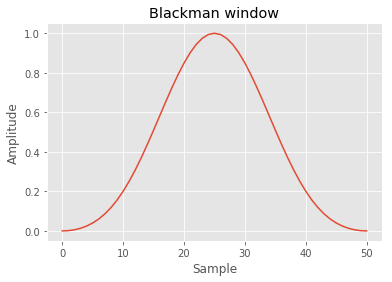

In [72]:
window = signal.blackman(51)
plt.plot(window)
plt.title("Blackman window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")

D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


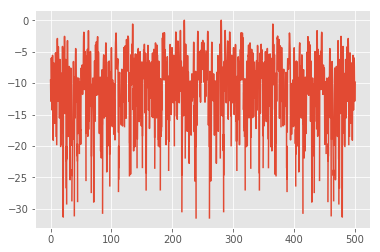

In [272]:
from spectrum import *
from pylab import *

psd = CORRELOGRAMPSD(ts, ts, lag=500)
f = linspace(0, 500, len(psd))
psd = cshift(psd, len(psd)/2)
plot(f, 10*log10(psd/max(psd)))
grid(True)

Rice

In [ ]:
# fx, ts.rolling(window=5,center=False).mean()[21:], ts

In [69]:
tau_max = 120
w_max = 1
delta = 0.01
# Ws = np.arange(0, w_max, delta)
Ws = [i for i in np.arange(0, 1, 0.01)] 

In [70]:
_right_part = [S(w, ts, tau_max, parsen2)*delta for w in Ws]

In [71]:
rm = [rice(t) for t in range(ts.shape[0])]

In [72]:
C = [np.random.rayleigh(math.sqrt((abs(S(w, ts, tau_max, barlett2)))*delta), 1)[0] for w in Ws]

eps = np.random.uniform(0, w_max, len(Ws))

def rice(t):
    return sum([C[w]*math.cos(w*t+eps[w]) for w in range(0, len(Ws))])

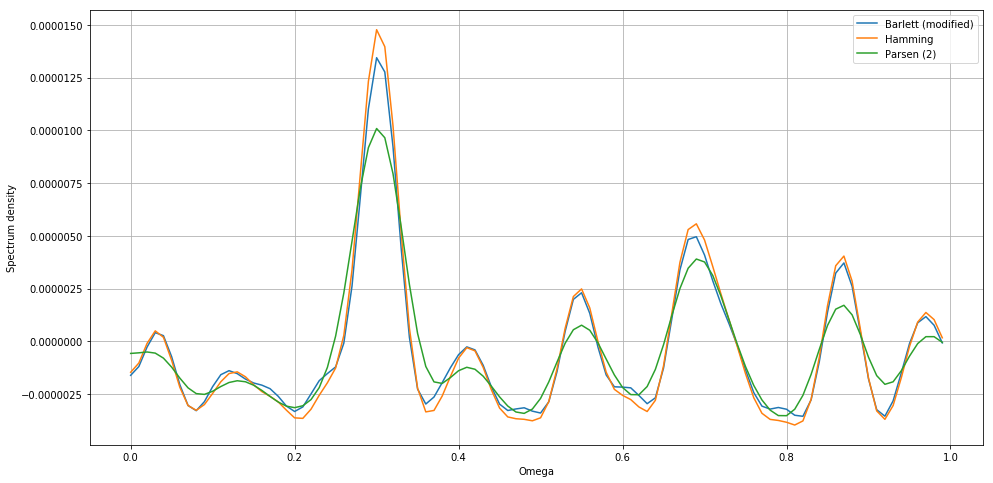

In [73]:
ws = [i for i in np.arange(0, 1, 0.01)]
plt.figure(figsize=(16, 8))
taumax = 120
plt.grid()
rice_ts = pd.Series([rice(t) for t in range(ts.shape[0])])
plt.xlabel('Freq')
plt.ylabel('Spectrum density')
plt.plot(ws, [S(w, rice_ts, taumax, barlett2) for w in ws], label='Barlett (modified)')
plt.plot(ws, [S(w, rice_ts, taumax, hamming)  for w in ws], label='Hamming')
plt.plot(ws, [S(w, rice_ts, taumax, parsen2)  for w in ws], label='Parsen (2)')
plt.legend()
plt.show()

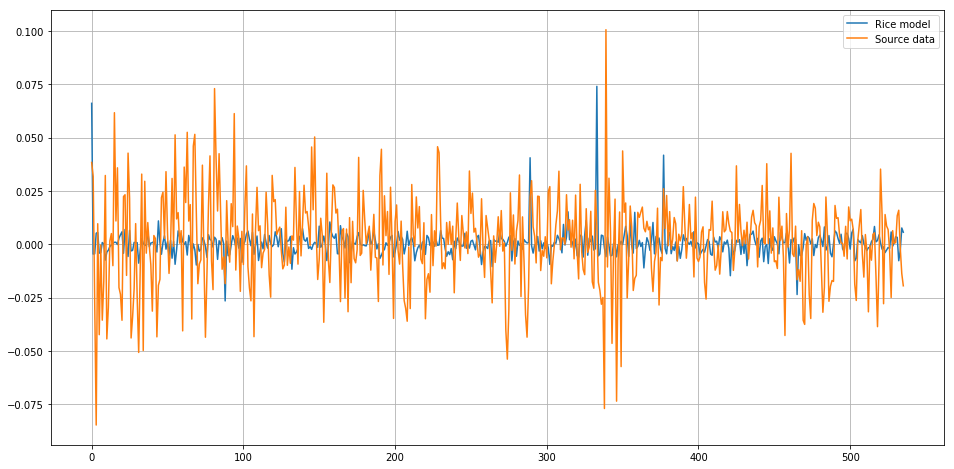

In [78]:
ax = ts
plt.figure(figsize=(16, 8))
plt.plot([rice(t) for t in range(ts.shape[0])], label='Rice model')
ts.plot(label='Source data')
plt.legend()
plt.grid()
plt.show()

In [74]:
n = ts.size

In [75]:
out = []
for i in range(n):
    out.append(np.sum(np.random.normal(0, 0.001, n)*np.cos(ts+np.random.random_sample(n))))

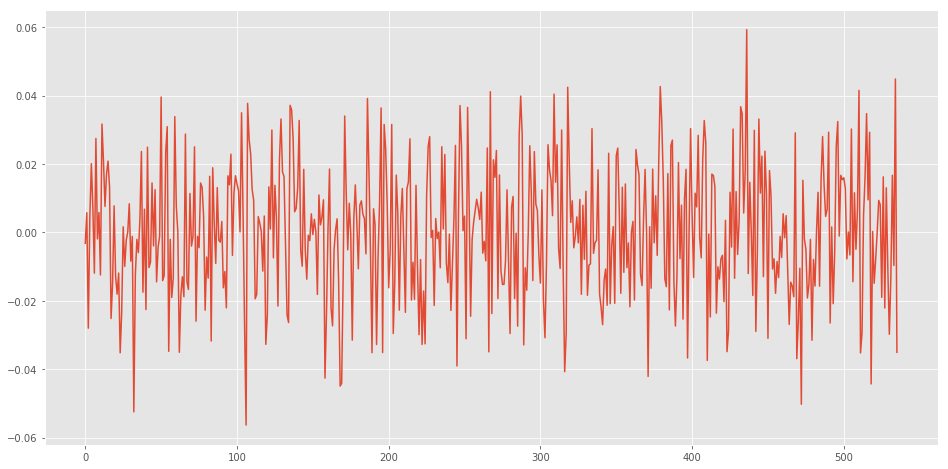

In [76]:
plt.figure(figsize=(16, 8))
plt.plot(np.array(out))

In [77]:
out = []
for i in range(n):
    out.append(np.sum(np.random.normal(0, 0.0002, n)*np.cos(moving_avg+np.random.random_sample(n))))

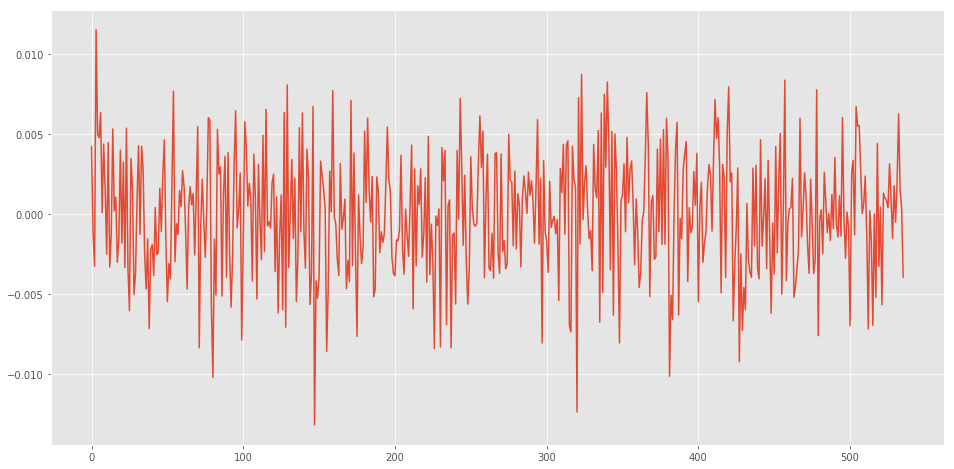

In [78]:
plt.figure(figsize=(16, 8))
plt.plot(np.array(out))

In [79]:
spec = ifft(acf(moving_avg[19:], nlags=n))

In [80]:
msum = 0.0
for i in range(19, 517):
    msum += spec[i]*(moving_avg[i+1]-moving_avg[i])

# Part 2

In [41]:
data = pd.read_excel('./Istanbul_StockMarket_09-11.xlsx', header=2)

In [49]:
data.head()

,date,value,gold,oil,aluminum
0,2009-01-05,0.038376,0.000000,0.003894,0.000000
1,2009-01-06,0.031813,0.004162,0.012866,0.004162
2,2009-01-07,-0.026353,0.017293,-0.028735,0.017293
3,2009-01-08,-0.084716,-0.040061,-0.000466,-0.040061
4,2009-01-09,0.009658,-0.004474,-0.012710,-0.004474


In [43]:
feature1 = data['NIKKEI']
feature2 = data['FTSE']

In [44]:
data = data[['date', 'USD BASED ISE']]

In [45]:
feature1.corr(feature2)

0.25523639081902699

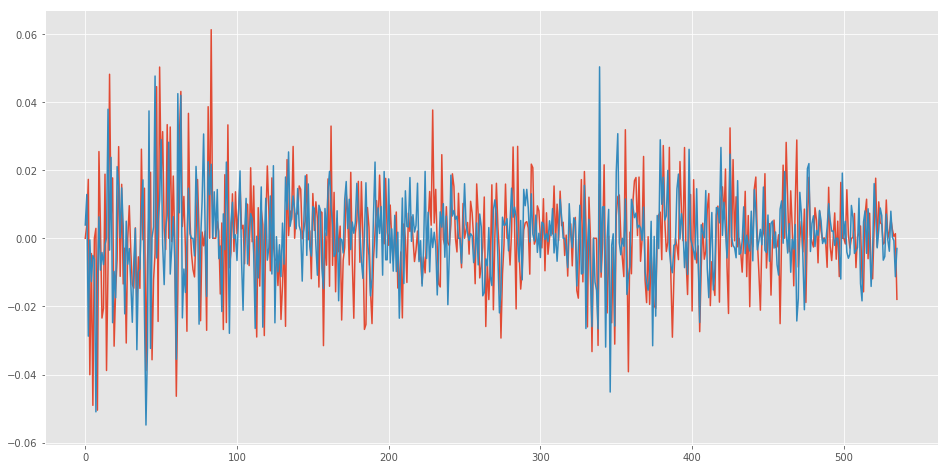

In [182]:
plt.figure(figsize=(16,8))
# plt.plot(ts)
plt.plot(feature1)
plt.plot(feature2)

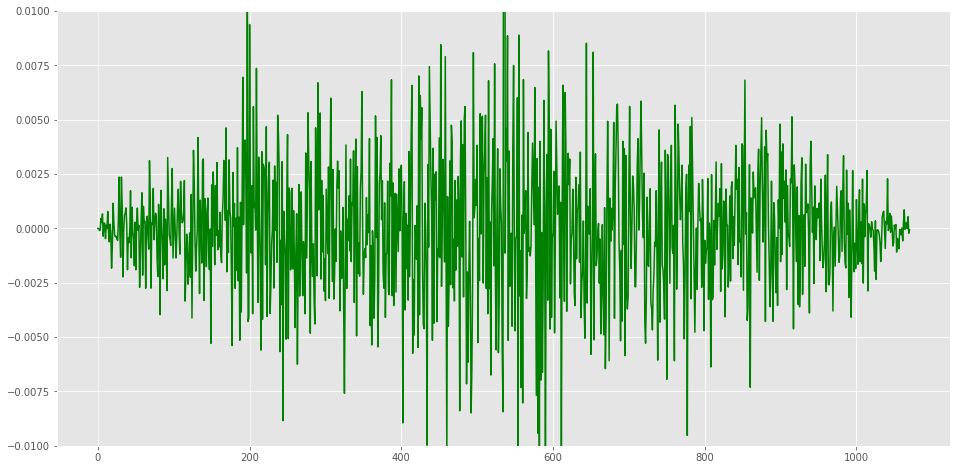

In [185]:
plt.figure(figsize=(16,8))
plt.ylim([-0.01, 0.01])
plt.plot(signal.correlate(feature1, feature2), color='green')

In [186]:
np.correlate(feature1, feature2)

array([ 0.02574745])

In [187]:
data.corr();

In [50]:
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))

In [51]:
xcov_monthly = [crosscorr(feature1, feature2, lag=i) for i in range(feature1.size)]
ts_1_monthly = [crosscorr(feature1, ts, lag=i) for i in range(feature1.size)]
ts_2_monthly = [crosscorr(ts, feature2, lag=i) for i in range(feature1.size)]

D:\Programs\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3159: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
D:\Programs\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


In [79]:
params_dic = {'NIKKEI': 8, 'FTSE': 1}

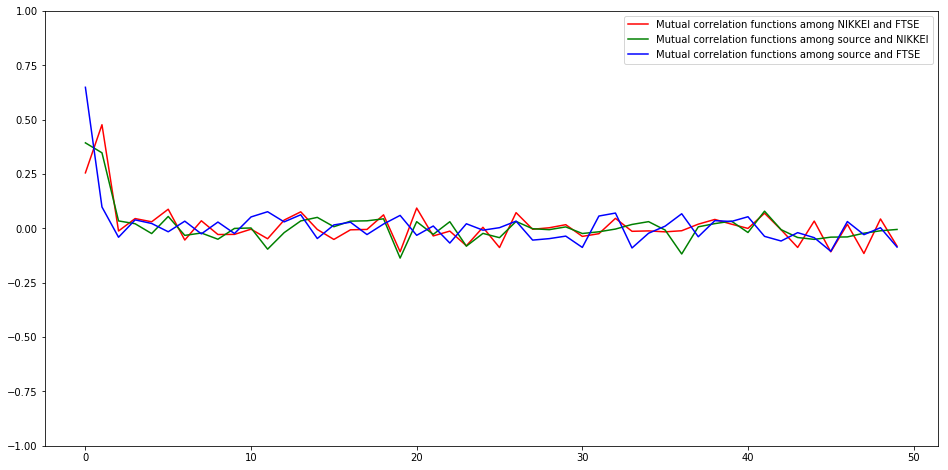

In [52]:
plt.figure(figsize=(16,8))
plt.ylim([-1, 1])
plt.plot(xcov_monthly[:50], color='red', label='Mutual correlation functions among NIKKEI and FTSE')
plt.plot(ts_1_monthly[:50], color='green', label='Mutual correlation functions among source and NIKKEI')
plt.plot(ts_2_monthly[:50], color='blue', label='Mutual correlation functions among source and FTSE')
plt.legend()

In [55]:
def get_EF(d, order, c):
    right = np.matrix(np.array([[auto_cov(_d, tau=abs(j-i), column=c) for j in range(1, order+1)] for i in range(1, order+1)]))  
    left = [auto_cov(_d, tau=i, column=c) for i in range(1, order+1)]  
    EF = np.linalg.solve(right, left)
    return EF

In [56]:
def nest_me(ef, f):
    _f = np.cumsum([0]+ list(f))
    EF = list()
    for l in range(len(_f)-1):
        EF.append(ef[_f[l]:_f[l+1]])
    return EF      

In [69]:
def get_lds_parameters(data, A, factors):
    EF = get_EF(_d=data, order=sum(factors.values()), c)
    EF_nested = nest_me(EF, factors.values())
    left_sum = np.array([[ cov(data, tau=i, A=A, B=factor) for i in range(1, f_order+1)]for factor, f_order in factors.items()])
    S1 = [[[ cov(data, tau=abs(j-i), A='value', B=factor) for j in range(1, f_order+1)] for i in range(1, f_order+1)]
                                for factor, f_order in factors.items()]
    auto_sum = list()
    for i in range(len(factors)):
            auto_sum.append(np.tensordot(S1[i], EF_nested[i], axes=((-1),(0))))
    left = left_sum-auto_sum
    S2 = [[[ auto_cov(data, tau=abs(j-i), column=factor, cor=True) for j in range(1, f_order+1)] for i in range(1, f_order+1)]
                                for factor, f_order in factors.items()]
    KSI = list()
    for i in range(len(factors)):
        KSI.append(np.linalg.solve(S2[i], left[i]))
    KSI = np.array(KSI)
    KSI = dict((zip(factors, KSI)))
    return EF, KSI

In [71]:
def cov(data, tau, A, B):
    _meanA = data[A].mean()
    varA = data[A].var()
    _valuesA = data[A].values
    _meanB = data[B].mean()
    varB = data[B].var()
    _valuesB = data[B].values
    N = len(_valuesA)
    return np.array([(_valuesA[t]-_meanA)*(_valuesB[t+tau]-_meanB)  for t in range(0, N-tau)]).mean()/(math.sqrt(varA*varB))

In [72]:
def auto_cov(data, tau, column='value', cor=False):
    _mean = data[column].mean()
    var = data[column].var()
    _values = data[column].values
    N = len(_values)
    if cor:
        return np.array([(_values[t]-_mean)*(_values[t+tau]-_mean)  for t in range(0, N-tau)]).mean()/var
    else:
        return np.array([(_values[t]-_mean)*(_values[t+tau]-_mean)  for t in range(0, N-tau)]).mean()

In [73]:
def lds(data, column, factors):
    auto_order = factors.pop('auto')
    EF, KSI = LDS_parameters_V2(A=column, factors=factors)
    _pred = np.zeros(data.shape[0])
    _data = data[column].values
    for t in range(auto_order, data.shape[0]):
        _res_auto = sum([EF[i]*_data[t-i-1] for i in range(auto_order)])
        _res_factors = sum(
        [sum([ KSI[factor][i] * data[factor][t-i-1]
              for i in range(f_order)]) for factor, f_order in factors.items()])
        _pred[t] = _res_auto + _res_factors 
    return _pred  

In [78]:
data['lds']=lds(column='value', factors=params_dic)
data['value'].plot()
data['lds'].plot(label='lds')
plt.show()

In [ ]:
def find_optimal_V2(order_max, data=data):
    errors = list()
    pars = list()
    y_real = data[col].values
    for auto in range(1, order_max):
        for oil in range(1, params_dic[0]):
            for aluminum in range(1, params_dic[1]):
                for gold in range(1, params_dic[2]):
                    pred = np.array(lds(column=col, factors=params_dic))
                    ers = np.square(pred[auto:]-y_real[auto:])
                    errors.append(ers.mean())
                    pars.append(params_dic)
    np.array(errors)
    return pars, errors

In [ ]:
data['value'].plot(label='Source process')
data['lds'].plot(label='Linear dinamic system')
plt.legend()
plt.show()

In [122]:
degree = 3

In [123]:
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
myDLM = dlm(ts, degree=degree)
myDLM = myDLM + dynamic(features=[feature1[:feature1.size//2], feature2[feature1.size//2:]], discount=1, name='EM and EU')

In [124]:
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
SP500Index = [[i] for i in feature1[:feature1.size//2]] + [[i] for i in feature2[feature1.size//2:]]
myDLM = dlm(ts, degree=degree)
myDLM = myDLM + dynamic(features=SP500Index, discount=1, name='SP500')

In [125]:
# myDLM.fitForwardFilter()
# myDLM.fitBackwardSmoother()
myDLM.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


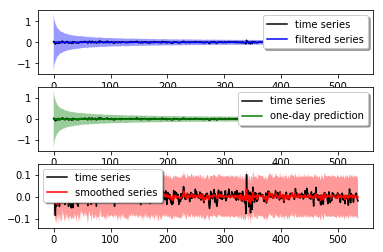

In [126]:
myDLM.plot()

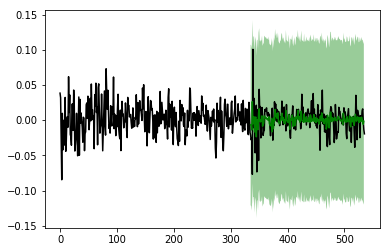

In [127]:
# myDLM.setConfidence(p = 0.95)
myDLM.plotPredictN(date=335, N=200)

In [128]:
mse = myDLM.getMSE()
residual = myDLM.getResidual(filterType='backwardSmoother')

MSE: 0.000344749691485


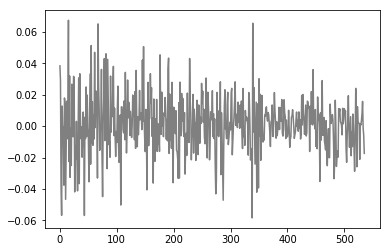

In [129]:
print("MSE:", mse)
plt.plot(residual, color="grey")